(content:references:tabular_part4)=
# Catalogue Data Part 2: *Finding Clusters and Overdensities*

***Author: Marc Hon (mtyhon@nus.edu.sg), Earl Patrick Bellinger (earl.bellinger@yale.edu)***

Machine learning techniques are particularly valuable in the data mining of kinematic information of stars in the Milky Way. A major contributor to this information over the past decade is the [***Gaia* mission**](https://www.esa.int/Science_Exploration/Space_Science/Gaia). *Gaia* is a space observatory that was launched by the European Space Agency (ESA) in December 2013 with the objective of creating a precise three-dimensional map of our Milky Way Galaxy by measuring the positions, distances, and motions of over a billion stars. The mission officially ended its science observations at the beginning of 2025.



## Star Clusters

A key task in Galactic astronomy is the identification of **star clusters**—gravitationally bound groups of stars that likely formed together from the same molecular cloud. These clusters can be broadly classified into two types:

1. **Open Clusters** -- These are loosely bound groups containing a few dozen to several thousand relatively young stars. Open clusters are typically located in the spiral arms of galaxies like the Milky Way. Over time, they can disperse due to internal dynamics and external tidal forces.

2. **Globular Clusters** --  These are densely packed, roughly spherical systems containing hundreds of thousands to millions of old stars. They are found primarily in the halos of galaxies. Many are thought to be the remnant cores of dwarf galaxies that were stripped of their outer stars through gravitational interactions with more massive systems like the Milky Way, leaving behind a compact stellar nucleus.


To find these clusters, **overdensities** are identified in kinematic space. Let's load a dataset that examines this.

In [25]:
import os
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
from astropy import coordinates as coords
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.style.use('science'); fs=15
plt.rcParams['text.usetex'] = False

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter3' / 'data'

In [7]:
gaia = pd.read_parquet(str(data_folder_path) + '/gaia.parquet'); gaia

,SOURCE_ID,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,65583742591605248,58.344770,22.688222,1.773985,0.118453,-2.811473,-6.346291,17.609467,18.786692,16.543457
1,65583875733141632,58.365304,22.711922,0.622843,0.121425,3.985970,-0.217382,17.743832,18.560629,16.845654
2,65583914390253056,58.383565,22.714186,0.421515,0.067883,1.139664,-3.740360,16.544357,17.014826,15.913900
3,65583948747956608,58.340348,22.701516,2.490116,0.274591,2.819814,-0.457338,19.026190,20.643658,17.811607
4,65583948749993216,58.341225,22.695062,4.679934,0.018546,20.197302,-35.987244,13.692286,14.414783,12.862484
...,...,...,...,...,...,...,...,...,...,...
23593,70229278000208768,56.246897,26.029548,1.073663,0.146265,4.603285,-14.751901,18.036743,19.125248,17.048775
23594,70368748476458240,57.661793,25.955714,4.020031,0.506745,27.559650,-17.419874,19.876314,20.031540,19.577700
23595,70368778537406976,57.670013,25.961820,2.125805,0.015136,21.125963,-8.930315,12.476719,13.043477,11.763743
23596,70368817195934720,57.643223,25.970933,0.927687,0.048298,4.152684,0.594143,16.208418,16.743715,15.522631


The DataFrame has the following columns:

| Column                | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `SOURCE_ID`           | Unique Gaia source identifier.                                              |
| `ra`                  | Right ascension (degrees), celestial longitude on the sky.                  |
| `dec`                 | Declination (degrees), celestial latitude on the sky.                       |
| `parallax`            | Parallax (mas), inverse of distance: $ d\ [\mathrm{pc}] = 1000 / \varpi $.|
| `parallax_error`      | Uncertainty in parallax (mas); large fractional errors imply poor distances.|
| `pmra`                | Proper motion in RA × cos(dec) (mas/yr), east–west angular motion.          |
| `pmdec`               | Proper motion in Dec (mas/yr), north–south angular motion.                  |
| `phot_g_mean_mag`     | Mean Gaia G-band magnitude (broad optical).                                 |
| `phot_bp_mean_mag`    | Mean BP-band magnitude (~330–680 nm).                                       |
| `phot_rp_mean_mag`    | Mean RP-band magnitude (~630–1050 nm).                                      |


```{admonition} Querying the *Gaia* Archive
:class: info

Measurements from the *Gaia* mission can be publicly accessed from the [ESA Gaia Archive](https://gea.esac.esa.int/archive/). Querying the archive efficiently relies on the use of an SQL-like language known as the **Astronomical Data Query Language (ADQL)**. Queries written in ADQL can be used directly in the online portal, though it can be used programmatically in Python. The following code snippet shows the query to obtain the dataset (`results`) used in the first part of this notebook, which is then converted into a `pandas` DataFrame.

```python
from astroquery.gaia import Gaia

adql_query = f"""
    SELECT
      g.source_id, g.ra, g.dec, 
      g.parallax, g.parallax_error, 
      g.pmra, g.pmdec,
      g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag
    FROM gaiadr3.gaia_source AS g
    WHERE CONTAINS(
        POINT('ICRS', g.ra, g.dec),
        CIRCLE('ICRS', 57, 24, 2)
      ) = 1
    AND g.phot_bp_mean_mag IS NOT NULL
    AND g.phot_rp_mean_mag IS NOT NULL
    AND g.astrometric_params_solved = 31
    """

job = Gaia.launch_job_async(adql_query)
results = job.get_results().to_pandas()
```


Here, we are looking at a patch of sky of radius 2$^{\circ}$ centered at (RA, Dec) = (57$^{\circ}$,24$^{\circ}$). Colour-coding by parallaxes, we observe nothing immediately distinct within the field. However, by analyzing the proper motion of this field of stars, we find a particularly interesting overdensity at about ($\mu_{\alpha*}$, $\mu_{\delta}$) $\sim$ (20, -45) mas/yr. Not only does this clump of stars have very similar proper motion (i.e., moving together in space), they have very similar parallaxes, meaning that their distances from the Sun are nearly identical. 

To single out this agglomeration, we turn to **clustering algorithms**.

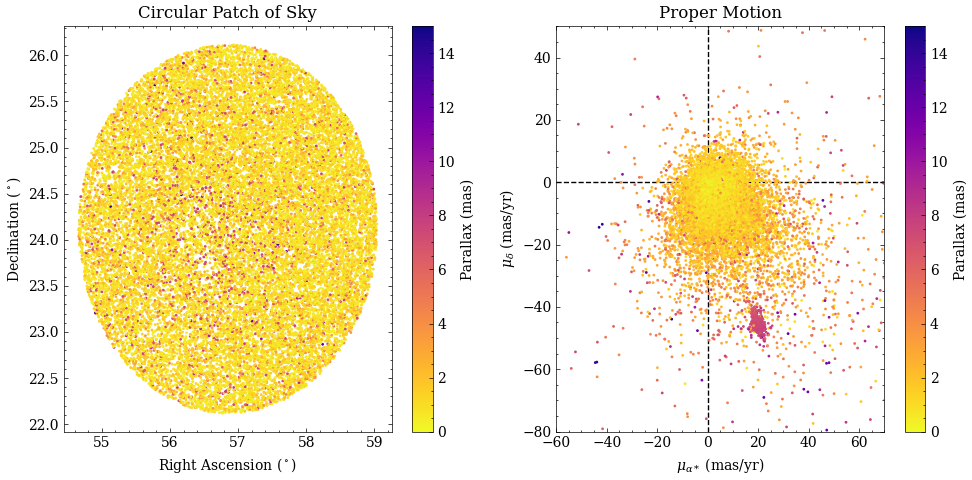

In [13]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
sc1 = ax1.scatter(gaia['ra'], gaia['dec'], c=gaia['parallax'], s=1, cmap='plasma_r', vmin=0, vmax=15)
cb1 = fig.colorbar(sc1, ax=ax1, label="Parallax (mas)")
ax1.set_xlabel("Right Ascension ($^\circ$) ")
ax1.set_ylabel("Declination ($^\circ$)")
ax1.set_title("Circular Patch of Sky")

sc2 = ax2.scatter(gaia['pmra'], gaia['pmdec'], c=gaia['parallax'], s=1, cmap='plasma_r', vmin=0, vmax=15)
ax2.axhline(0, ls='--', c='k', zorder=-999, lw=1)
ax2.axvline(0, ls='--', c='k', zorder=-999, lw=1)
ax2.set_xlim([-60, 70])
ax2.set_ylim([-80, 50])
cb2 = fig.colorbar(sc2, ax=ax2, label=r"Parallax (mas)")
ax2.set_xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
ax2.set_ylabel(r"$\mu_{\delta}$ (mas/yr)")
ax2.set_title("Proper Motion")

plt.tight_layout(); plt.show()

## Clustering Overdensities

While a variety of clustering algorithms exists (e.g., K-Means, Spectral Clustering, HDBSCAN, FOPTICS, see [here](https://scikit-learn.org/stable/modules/clustering.html)), we will use the novel approach [AstroLink](https://github.com/william-h-oliver/astrolink/tree/main) -- a method specifically designed for hierarchical clustering in astrophysical datasets, which can be noisy and have structure across varying scales.

To see this in action, let's import the library and prepare the data.

In [19]:
from astrolink import AstroLink
from sklearn.preprocessing import RobustScaler

features = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
data = np.array([gaia[feature] for feature in features]).T
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

Next, let's run the clustering algorithm on the data. We will use the positions, motion, and parallaxes of the stars as our input features.

```{admonition} Scaling Features
:class: tip
The scaling of input features with `scikit-learn`'s `RobustScaler` is particularly helpful when dealing with kinematic data. This scaling approach scales features by their median and interquartile range, and not only removes disparate scales from the data, but is less sensitive to strong outliers -- a common occurrence in large datasets such as from *Gaia*.

Note that by default, `AstroLink` already scales features to have unit variance through its `adaptive` argument at initialization.
```

In [ ]:
clusterer = AstroLink(scaled_data, S=5)
clusterer.run()

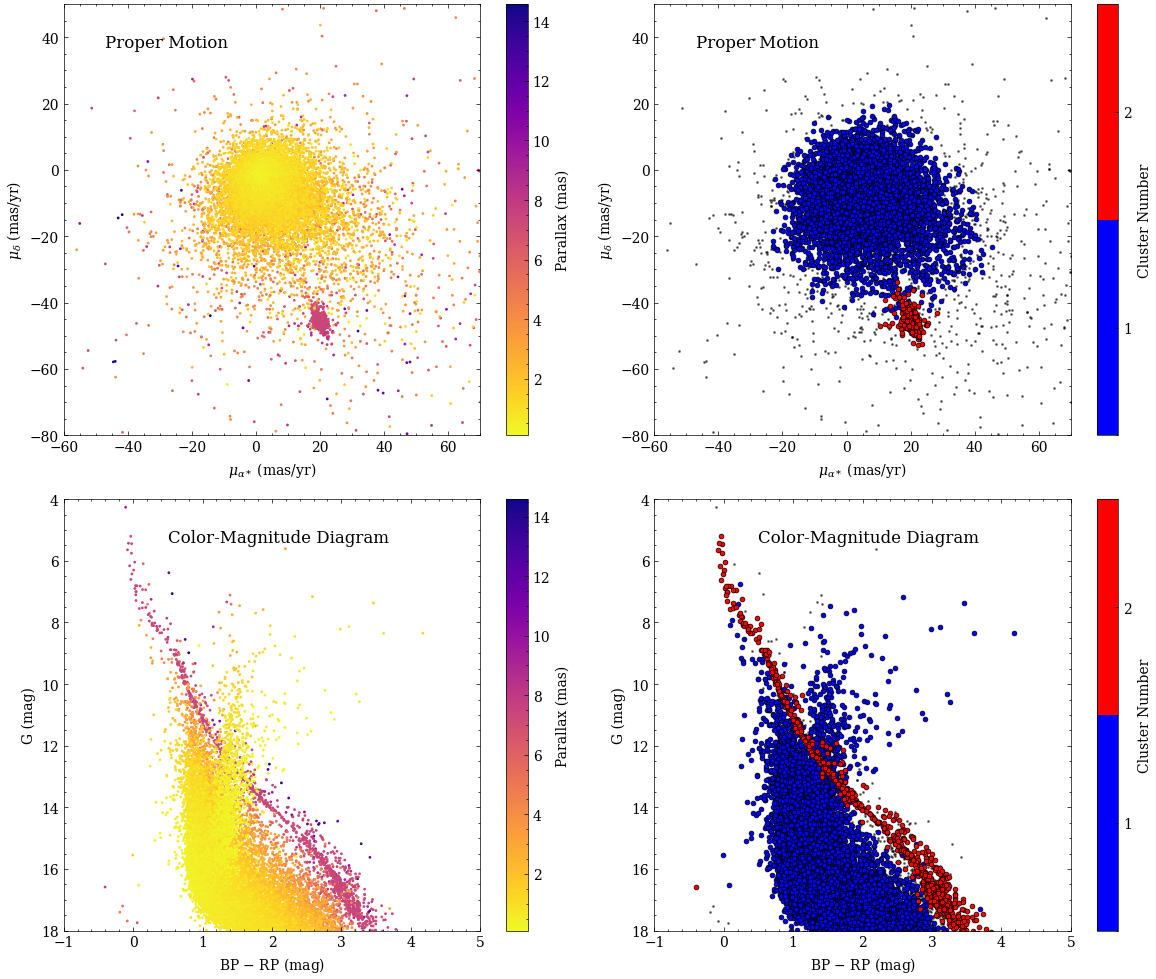

In [85]:
ords = clusterer.ordering
ord_data = data[ords]

color_ = (gaia['phot_bp_mean_mag'] - gaia['phot_rp_mean_mag']).values[ords]
magnitude_ = gaia['phot_g_mean_mag'].values[ords]
pmra_ = gaia['pmra'].values[ords]
pmdec_ = gaia['pmdec'].values[ords]

nclusters = len(clusterer.clusters) - 1 # First Cluster is the Global Tree
_cmap = plt.colormaps['bwr']
cmap = ListedColormap(_cmap(np.linspace(0, 1, nclusters)))
norm_ = BoundaryNorm(boundaries=range(nclusters + 1), ncolors=nclusters)

fig = plt.figure(figsize=(12,10))
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222)
ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)

im1 = ax1.scatter(ord_data[::-1,-2], ord_data[::-1,-1], c=ord_data[::-1,-3],
            s=1, cmap='plasma_r')
ax2.scatter(ord_data[:,-2], ord_data[:,-1], c='k', s=1, alpha=0.5)

ax3.scatter(color_[::-1], magnitude_[::-1], c=ord_data[::-1,-3],
            s=1, cmap='plasma_r')

ax4.scatter(color_[::-1], magnitude_[::-1], c='k', s=1, alpha=0.5)

for k, clust in enumerate(clusterer.clusters):
    if k == 0:  # First Cluster is the Global Tree
        continue
    ax2.scatter(ord_data[clust[0]: (clust[1]-1),-2], ord_data[clust[0]: (clust[1]-1),-1], color=cmap(norm_(k-1)), s=12,
               edgecolor='k', lw=0.5)
    ax4.scatter(color_[clust[0]: (clust[1]-1)], magnitude_[clust[0]: (clust[1]-1)], color=cmap(norm_(k-1)), s=12,
               edgecolor='k', lw=0.5)

for ax in [ax1, ax2]:
    ax.set_xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
    ax.set_ylabel(r"$\mu_{\delta}$ (mas/yr)")
    ax.text(x=0.1, y=0.9, transform=ax.transAxes, s='Proper Motion', fontsize=fs-3)
    ax.set_xlim([-60, 70])
    ax.set_ylim([-80, 50])
    
for ax in [ax3, ax4]:
    ax.invert_yaxis()
    ax.set_xlim([-1, 5])
    ax.set_ylim([18, 4])
    ax.set_xlabel(r"BP $-$ RP (mag)")
    ax.set_ylabel(r"G (mag)")
    ax.text(x=0.25, y=0.9, transform=ax.transAxes, s='Color-Magnitude Diagram', fontsize=fs-3)

boundaries = np.arange(1, nclusters + 2) 
norm = mcolors.BoundaryNorm(boundaries, nclusters)
tick_positions = np.arange(1.5, nclusters + 1.5)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar1 = fig.colorbar(im1, ax=ax1, label=r"Parallax (mas)")
cbar2 = fig.colorbar(sm, ax=ax2, ticks=tick_positions, boundaries=boundaries, extend='neither')
cbar2.ax.set_yticklabels([str(i) for i in range(1, nclusters + 1)])
cbar2.set_label("Cluster Number")
cbar3 = fig.colorbar(im1, ax=ax3, label=r"Parallax (mas)")
cbar4 = fig.colorbar(sm, ax=ax4, ticks=tick_positions, boundaries=boundaries, extend='neither')
cbar4.ax.set_yticklabels([str(i) for i in range(1, nclusters + 1)])
cbar4.set_label("Cluster Number")
plt.tight_layout()
plt.show()

We find that the clustering algorithm identifies two groups: the first being overdensity in proper motion identified earlier, while the second is simply other background stars in the field. In the bottom panels above, the overdensity indeed corresponds to a very specific sequence of stars along in the color-magnitude diagram! This is no coincidence, for these are main sequence stars belonging to the young open cluster **Melotte 22**, though it is much more famously known by another name.

Let's examine how the clustering algorithm works.

## The Aggregation Process

Clustering algorithms generally operate by grouping points that exhibit **strong similarity or affinity**, though the way similarity is defined and measured varies significantly between methods.

The core working of `AstroLink` is the following: 
> Merge data points into clusters by following strong, high-density connections, while recording how distinct each cluster's **prominence**.

The aggregation steps, also outlined [here](https://astrolink.readthedocs.io/en/latest/howitworks.html), are as follows:

**Density Estimation:** Each point is assigned a `logRho` value that represents its local density. The value is estimated based on a kernel function of each point's `k_den` nearest neighbours. A higher `logRho` corresponds to denser regions.
**Nearest Neighbour Connection:** `k_link` nearest neighbors are found for each point, and edges between the neighbours are created. The **weight** or strength of each connection is determined as min(`logRho[i]`, `logRho[j]`).
**Sort Edges by Strength:** Sort all edges in **descending** order of weight. This is done within the vicinity of each neighbourhood, and creates ordered lists locally.
**Merge Points into Clusters:** In each neighbourhood, traverse edges in order:
 - If neither point is assigned → create new ordered list
 - If one point is in an ordered list → add the other
 - If both are in different lists → merge them into a group.
   
  The group tracks the hierarchical merging of lists and is illustrated in the following example:

```{figure} images/astrolink.png
---
height: 500px
width: 800px
name: astrolink
---
Sequential schematic of the `AstroLink` aggregation process. The process begins by the sorting of edges ($E$) by decreasing density to form ordered lists ($O$) locally, and the hierarchical merging of ordered lists to form groups ($G$).
Image adapted from [Oliver et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.530.2637O/abstract).

```

At this stage, it is worth visualizing how this corresponds to the clustering of our *Gaia* dataset. 

In [159]:
def cluster_thresholds(clusterer, thresh, data):
    ords = clusterer.ordering[::-1]
    thresh_cond = (clusterer.logRho > thresh)
    
    fig = plt.figure(figsize=(12,5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    
    im1 = ax1.scatter(data[ords,-2], data[ords,-1], c=clusterer.logRho[ords], s=5)
    
    ax1.scatter(data[thresh_cond,-2], data[thresh_cond,-1], c='r', s=5, edgecolor='k', lw=0.2)
    ax1.set_xlim([-60, 70])
    ax1.set_ylim([-80, 50])
    ax1.set_xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
    ax1.set_ylabel(r"$\mu_{\delta}$ (mas/yr)")
    ax1.text(x=0.1, y=0.9, transform=ax1.transAxes, s='Proper Motion', fontsize=fs-3)


    cb = fig.colorbar(im1, ax=ax1, label='Normalized $\\log \\rho$')
    ax2.plot(range(clusterer.n_samples), clusterer.logRho[ords[::-1]], c='k')
    ax2.set_xlim(0, np.max(range(clusterer.n_samples)))
    ax2.axhline(y=thresh, c='r', ls='--')
    ax2.set_xlabel('Ordered Index')
    ax2.set_ylabel('Normalized $\\log \\rho$')
    ax2.set_ylim(0., 1.)

    logRho_ordered = clusterer.logRho[clusterer.ordering]
    for i, (clst, clst_id) in enumerate(zip(clusterer.clusters, clusterer.ids)):
        if i > 0:
            start, end = clst[0], clst[1]
            ord_dens_clst = logRho_ordered[start:end]
            x = np.arange(start, end)
    
            mask = ord_dens_clst > thresh
            if np.any(mask):
                x_masked = x[mask]
                y_masked = ord_dens_clst[mask]
                ax2.fill_between(x_masked, y_masked, thresh, color='r', zorder=1, alpha=0.5)

    plt.tight_layout(h_pad=2)
    plt.show()

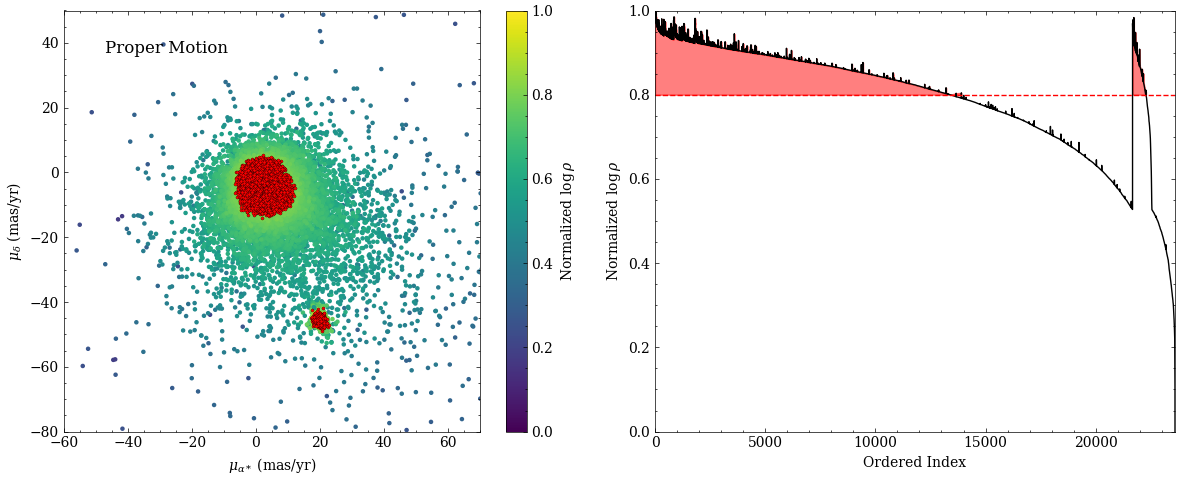

In [266]:
thresh = 0.8
cluster_thresholds(clusterer, thresh, data)

Above, the proper motion of the stars are coloured according to the calculated log density, revealing that the most dense regions are near the origin (low observed motion) and the overdensity corresponding to **Melotte 22**. Adjusting the value of `thresh` selects **only stars above a certain density threshold**, with the greater the number of stars above the threshold, the larger the cluster.

```{admonition} Understanding the Merging
:class: note
Adjust the value of `thresh` above. At what stage does the central cluster connect to the overdensity represented by **Melotte 22**? What feature in the $\log\rho$-index curve does this correspond to?
```

The final step of the `AstroLink` algorithm is to calculate **prominences** and **significances**. 

Each group’s prominence $P_g$ is computed as:

$$
P_g = \log \hat{\rho}_{\text{max}, g} - \log \hat{\rho}_{\text{boundary}, g} - \log \hat{\rho}_{\text{noise}, g}
$$

- $ \log \hat{\rho}_{\text{max}, g} $: peak density within the group  
- $ \log \hat{\rho}_{\text{boundary}, g} $: saddle density where the group merges into another  
- $ \log \hat{\rho}_{\text{noise}, g} $: correction for intra-group noise


Prominences are transformed into a *significance score* using a fitted Beta–Uniform mixture model:
- A **Beta distribution** models noise-like groups (low prominence)
- A **Uniform tail** models real clusters (high prominence)
- The **cutoff** point $c$ separates noise from clusters and ensures continuity

The following image demonstrates these on a toy example.

```{figure} images/astro_prominences.png
---
height: 300px
width: 500px
name: astro_prominences
---
Depiction of prominences and significances from  `AstroLink` on a toy dataset, adopted from Fig. 5 of [Oliver et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.530.2637O/abstract).

```

The final outputs of the algorithm are the following:
- `ordering`: data points listed in merge order  
- `groups`: index ranges of each cluster in `ordering`  
- `prominences` and `significances`: density-based prominences/significance of each cluster


```{admonition} Exercise
:class: note
Within the original field of stars, **Melotte 22** spatially did not appear strongly clustered as opposed to viewing its proper motion. Verify that it can still be clustered when RA and Declination are not included as features in the clustering.
```


## Connection with Neural Density Estimation

`AstroLink` relies on an estimate of **density**, $\log\rho$ calculated from distances to nearest neighbours. This captures how tightly packed points are in a small region of space. Similarly, normalizing flows estimate the global probability density $\log p(x)$, assigning higher log-probability to regions where data points are more concentrated.

In the following, a Neural Spline Flow normalizing flow is trained to model the density of the *Gaia* dataset.

In [235]:
import torch
import zuko
from torch.utils.data import TensorDataset, DataLoader

X = scaled_data
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor[:,2] = X_tensor[:,2]/10. # transforming to make the scales more comparable
X_tensor[:,3] = X_tensor[:,3]/10.
X_tensor[:,4] = X_tensor[:,4]/10. 

X_dataset = TensorDataset(X_tensor)
loader = DataLoader(X_dataset, batch_size=64, shuffle=True)

In [232]:
# Neural spline flow (NSF) with 5 sample features, 0 conditional features
flow = zuko.flows.NSF(5, 0, transforms=3, hidden_features=[32] * 5)

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    tot_loss = []
    for x in loader:
        loss = -flow().log_prob(x[0])  # -log p(x)
        loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()
        tot_loss.append(loss.item())
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {np.mean(tot_loss)}')

Epoch 0, Loss: -0.4002267703777406
Epoch 1, Loss: -1.5479340125228653
Epoch 2, Loss: -1.675556653075748
Epoch 3, Loss: -1.736020929283566
Epoch 4, Loss: -1.8236955186215842
Epoch 5, Loss: -1.9042016991431796
Epoch 6, Loss: -1.9086713949193153
Epoch 7, Loss: -1.9466577362884998
Epoch 8, Loss: -1.9518855249655602
Epoch 9, Loss: -1.9584463178949951
Epoch 10, Loss: -1.9592240372001317
Epoch 11, Loss: -1.976104675108178
Epoch 12, Loss: -1.9943319397567087
Epoch 13, Loss: -1.9958365696878615
Epoch 14, Loss: -2.005933244376971
Epoch 15, Loss: -2.0063102466627187
Epoch 16, Loss: -2.0153118391347125
Epoch 17, Loss: -2.023337807758714
Epoch 18, Loss: -2.0275023159618946
Epoch 19, Loss: -2.0442777371341943


Despite limited training, the flow performs reasonably at approximating the distribution of stars in the dataset, as seen below for the proper motion. 

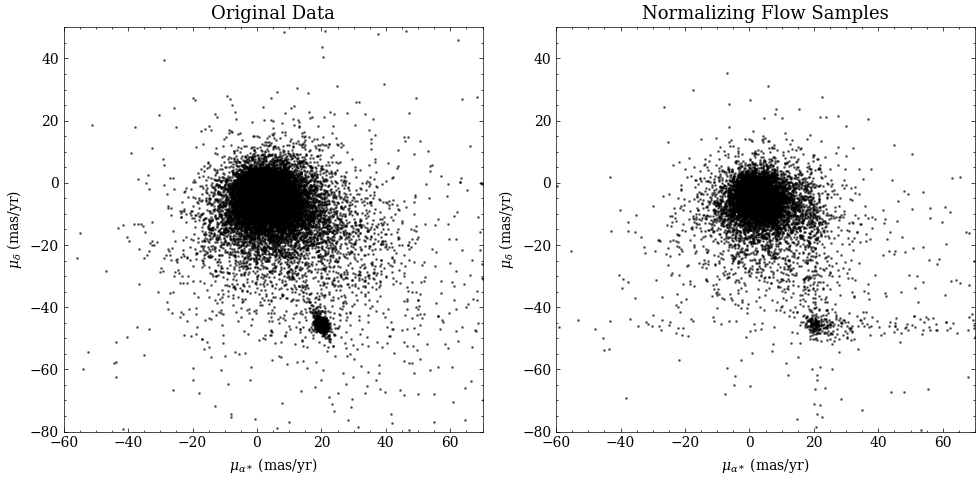

In [240]:
samps = flow().sample([10000]).numpy()
samps[:,2] = samps[:,2]* 10.  # reversing the transformation
samps[:,3] = samps[:,3]* 10.
samps[:,4] = samps[:,4]* 10.
samps = scaler.inverse_transform(samps)

tens = X_tensor.numpy().copy()
tens[:,2] = tens[:,2]* 10.  # reversing the transformation
tens[:,3] = tens[:,3]* 10.
tens[:,4] = tens[:,4]* 10.
tens = scaler.inverse_transform(tens)

fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

ax1.scatter(tens[:,-2], tens[:,-1], s=1, c='k', alpha=0.5)
ax2.scatter(samps[:,-2], samps[:,-1], s=1, c='k', alpha=0.5)

ax1.set_title('Original Data', fontsize=fs-2)
ax2.set_title('Normalizing Flow Samples', fontsize=fs-2)

for ax in [ax1, ax2]:
    ax.set_xlim([-60, 70])
    ax.set_ylim([-80, 50])    
    ax.set_xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
    ax.set_ylabel(r"$\mu_{\delta}$ (mas/yr)")
plt.tight_layout(h_pad=2)
plt.show()

### Density Estimation with the Flow
While the flow defines a generative model, the goal of in this context is to have it as a density estimator, in which we want to
> **Estimate the log-probability of data points as a proxy for global density.**

To do this, we may simply calculate the `log_prob` evaluated by the flow as the following:

In [241]:
logprobs = flow().log_prob(X_tensor).data.cpu().numpy()

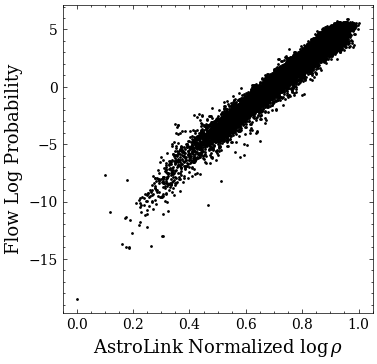

In [250]:
fig = plt.figure(figsize=(4,4))
plt.scatter(clusterer.logRho, logprobs, s=1, c='k')
plt.xlabel('AstroLink Normalized $\\log\\rho$', fontsize=fs-2)
plt.ylabel('Flow Log Probability', fontsize=fs-2); plt.show()

There is indeed a good correspondence between the density evaluated by `AstroLink` and the log probability of the flow! We therefore can expect that by setting log probability thresholds on a flow that models the data, we are able to reveal overdensities in the dataset.

To more concretely demonstrate this, let's proceed with a fresh initialization of `AstroLink` over the *Gaia* dataset. In this particular line of code:
```python
clusterer_new.logRho = logprobs/np.max(logprobs)      
```
We will be replacing the density estimated by `AstroLink` with the normalized log probability from the flow, scaled to the range of [0,1].

In [260]:
## Manually get kNN ##
clusterer_new = AstroLink(scaled_data, S=5)
clusterer_new.transform_data()
clusterer_new.estimate_density_and_kNN()
nearest_neighbours = clusterer_new.kNN

clusterer_new.logRho = (logprobs - logprobs.min())/(logprobs.max() - logprobs.min()) # Substitute density
clusterer_new.aggregate() # Calculate ordering using log probs
clusterer_new.compute_significances()
clusterer_new.extract_clusters()

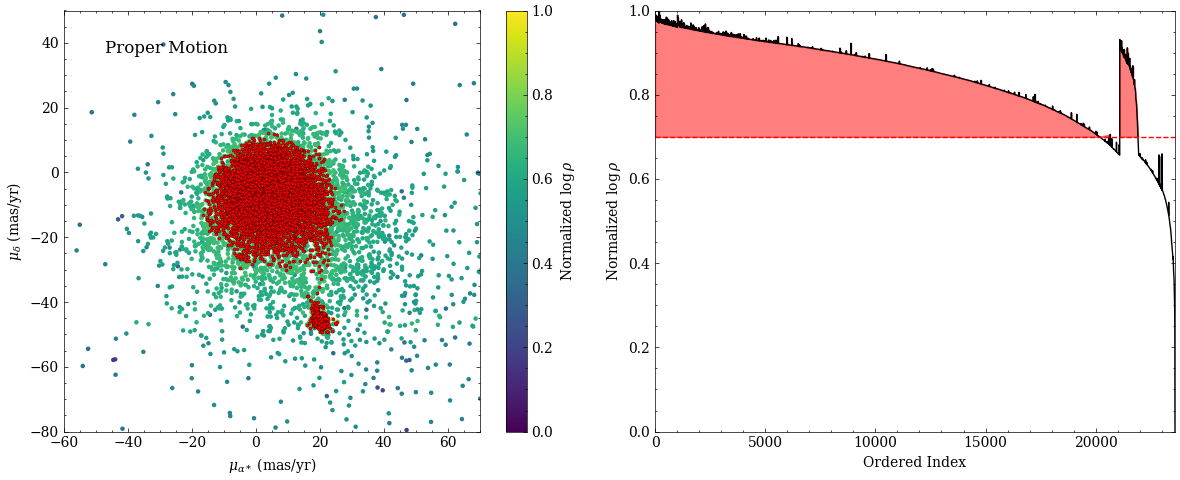

In [267]:
thresh = 0.7
cluster_thresholds(clusterer_new, thresh, data)

## Clustering Stellar Streams

The exquisite data from *Gaia* allows us to identify groups of stars thought to be accreted from outside the Milky Way, which typically happens early in our Galaxy's own history. These stars are described as being **phase mixed**, meaning that they no longer clump together at a single position in velocity and space like star clusters, but have been tidally dispersed throughout the Milky Way potential. 

However, these stars may still share similar dynamics, as they will continue to follow closely the trajectory of the system they used to belong to (e.g., dwarf galaxy). By clustering **kinematic properties of their orbits**, astronomers thus aim to find accreted groups of stars and build a picture of the Galaxy's formation history. 

Let's examine the *Gaia* dataset from [Dodd et al. (2022)](https://www.aanda.org/articles/aa/pdf/2023/02/aa44546-22.pdf), which contains the following kinematic information.

In [269]:
stream = pd.read_parquet(str(data_folder_path) + '/stream.parquet'); stream

,Lz,Lperp,En,vR,vphi,vz,labelOri,GaiaDR3
0,1992.978166,170.537312,-103341.621919,-214.151461,212.153457,-20.237207,-1,3450980766068770304
1,62.965847,32.347314,-133908.214665,67.586464,69.553004,5.685157,-1,3450869676738158848
2,768.603329,100.716736,-137623.940939,NaN,NaN,NaN,-1,5918256954391665024
3,250.633749,496.880744,-141668.714915,-71.932065,57.485603,-45.793720,-1,3829892917041332608
4,749.445831,618.477728,-148169.458172,180.652753,406.035578,-525.860530,-1,4124284131794966656
...,...,...,...,...,...,...,...,...
193826,50.750393,83.053458,-185307.388029,-129.391454,159.421807,10.893195,-1,6029473247149249408
193827,-449.244641,393.685482,-153560.068276,NaN,NaN,NaN,-1,5242677088572700160
193828,622.397081,650.992679,-143357.050733,NaN,NaN,NaN,-1,4112018834700648576
193829,574.687362,434.642499,-155875.299936,178.640887,232.985835,-79.046176,-1,4123954003445940864


The above DataFrame has the following columns:

| Column                | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| `GaiaDR3`           | Unique Gaia source identifier.                                              |
| `labelOri`                  | Cluster identification of stellar stream membership, with `-1` indicating no membership                  |
| **`vR`** $(v_R)$     | Radial velocity in the plane: motion toward or away from the Galactic center in units of km s$^{-1}$.  |
| **`vphi`** $(v_\phi)$   | Azimuthal (tangential) velocity around the Galactic center in units of km s$^{-1}$. Defined to be positive for prograde motion. | 
| **`vz`** $(v_z)$    | Vertical velocity: motion above or below the Galactic plane in units of km s$^{-1}$.   |
| **`Lz`** $(L_z)$    | Specific angular momentum about the Galactic $ z $-axis: $ L_z = R \cdot v_\phi $ in units of kpc km s$^{-1}$. Defined to be positive values for prograde orbits (same sense as Galactic rotation). |
| **`Lperp`** $(L_{\perp})$  | Magnitude of angular momentum perpendicular to $ L_z $ in in units of kpc km s$^{-1}$. Indicates how tilted the orbit is with respect to the Galactic plane. |
| **`En`** ($E$)     | Specific orbital energy $ E = \frac{1}{2}(v_R^2 + v_\phi^2 + v_z^2) + \Phi(R, z) $, dependent on the Milky Way potential $ \Phi(R, z)$. Values presented in units of kpc km s$^{-1}$.| 


```{admonition} Cylindrical coordinate system
:class: seealso
The cylindrical coordinate system, represented by quantities $R, \phi,$ and $z$ (see schematic below) provides a natural framework for describing stellar motion relative to the Milky Way disk. It is particularly well-suited for analyzing dynamics in a rotating, disk-like system, such as motion with respect to Galactic rotation.


```{figure} images/cylindrical.png
---
height: 370px
width: 500px
name: cylindrical
---
Cylindrical polar coordinates $R, \phi, z$ with the origin at the Galactic Center (GC). Image from [Sparke and Gallagher (2007).](https://www.cambridge.org/highereducation/books/galaxies-in-the-universe/905351A922D65FCD8D27EA38AB4BB5BE)

```


### Clustering in Velocity Space 

A view commonly used to find co-moving groups of stars is in **velocity space**, shown as the following:

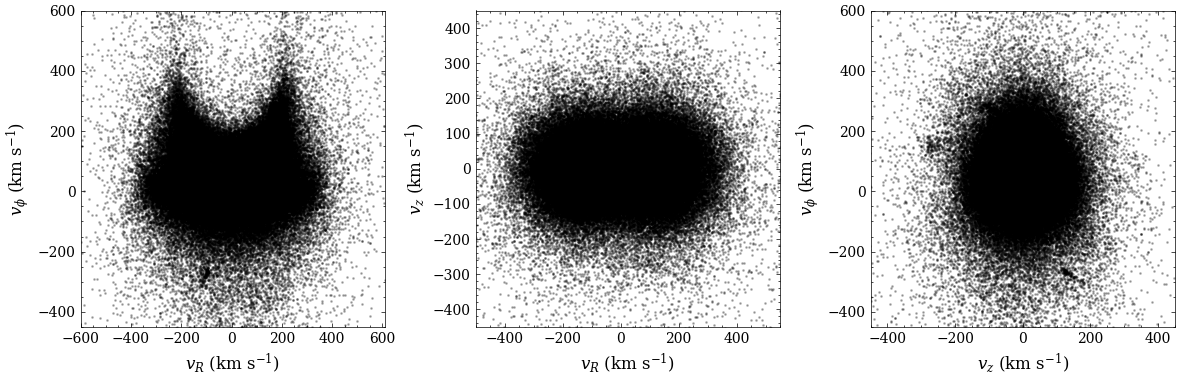

In [283]:
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

ax1.scatter(stream.vR, stream.vphi, s=1, c='k', alpha=0.25)
ax2.scatter(stream.vR, stream.vz, s=1, c='k', alpha=0.25)
ax3.scatter(stream.vz, stream.vphi, s=1, c='k', alpha=0.25)

ax1.set_xlim([-600, 610])
ax2.set_xlim([-500, 550])
ax3.set_xlim([-450, 450])
ax1.set_ylim([-450, 600])
ax2.set_ylim([-450, 450])
ax3.set_ylim([-450, 600])

ax1.set_xlabel('$v_R$ (km s$^{-1}$)', fontsize=fs-3)
ax2.set_xlabel('$v_R$ (km s$^{-1}$)', fontsize=fs-3)
ax3.set_xlabel('$v_z$ (km s$^{-1}$)', fontsize=fs-3)

ax1.set_ylabel('$v_{\phi}$ (km s$^{-1}$)', fontsize=fs-3)
ax2.set_ylabel('$v_z$ (km s$^{-1}$)', fontsize=fs-3)
ax3.set_ylabel('$v_{\phi}$ (km s$^{-1}$)', fontsize=fs-3)

plt.tight_layout()
plt.show()

To date, multiple kinematic substructures have been discovered around the Milky Way, whose presence in velocity space can be seen below:

```{figure} images/stream_vel.png
---
height: 250px
width: 800px
name: stream_vel
---
The presence of known stellar streams in velocity space. Image adopted from Fig. 3 of [Dodd et al. (2022)](https://www.aanda.org/articles/aa/pdf/2023/02/aa44546-22.pdf).

```

```{admonition} Exercise: Clustering in Velocity Space
:class: note

Perform clustering using `AstroLink` using `vR`, `vphi`, and `vz`. How many of the known stellar streams in the above Figure can be recovered?

```

### Clustering in Integral of Motion (IoM) Space 

Integrals of Motion are quantities that remain constant along an orbit in a time-independent gravitational potential. Unlike velocity space, which captures a star’s instantaneous motion, IoMs provide long-term invariants of orbital dynamics and can identify coherent structures that have phase-mixed in velocity but remain clustered in conserved quantities.

Commonly used IoMs to find stellar streams are angular momenta ($L_z$, $L_{\perp}$) and total energy $E$:

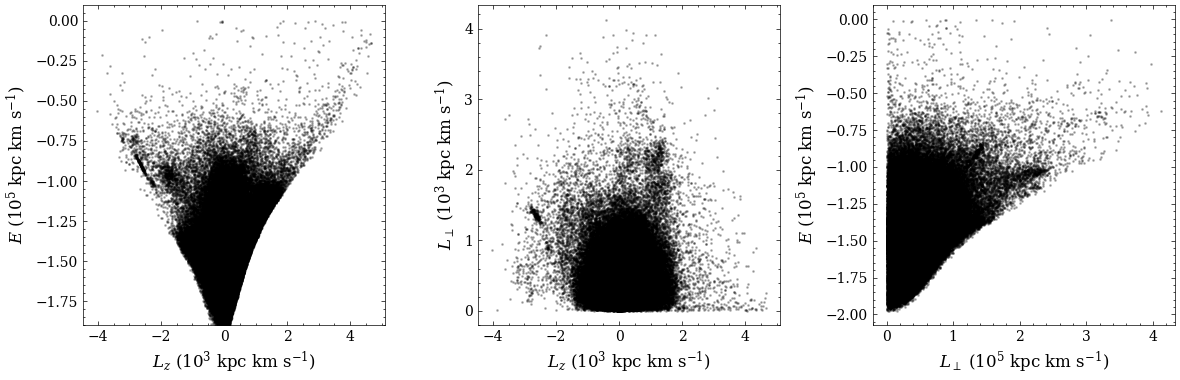

In [288]:
fig = plt.figure(figsize=(12,4))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

ax1.scatter(stream.Lz/1000., stream.En/1e5, s=1, c='k', alpha=0.25)
ax2.scatter(stream.Lz/1000., stream.Lperp/1000., s=1, c='k', alpha=0.25)
ax3.scatter(stream.Lperp/1000., stream.En/1e5, s=1, c='k', alpha=0.25)

# ax1.set_xlim([-600, 610])
# ax2.set_xlim([-500, 550])
# ax3.set_xlim([-450, 450])
ax1.set_ylim([-1.9, None])
# ax2.set_ylim([-450, 450])
# ax3.set_ylim([-450, 600])

ax1.set_xlabel('$L_z$ ($10^3$ kpc km s$^{-1}$)', fontsize=fs-3)
ax2.set_xlabel('$L_z$ ($10^3$ kpc km s$^{-1}$)', fontsize=fs-3)
ax3.set_xlabel('$L_{\perp}$ ($10^5$ kpc km s$^{-1}$)', fontsize=fs-3)

ax1.set_ylabel('$E$ ($10^5$ kpc km s$^{-1}$)', fontsize=fs-3)
ax2.set_ylabel('$L_{\perp}$ ($10^3$ kpc km s$^{-1}$)', fontsize=fs-3)
ax3.set_ylabel('$E$ ($10^5$ kpc km s$^{-1}$)', fontsize=fs-3)
plt.tight_layout()
plt.show()

Known kinematic substructures around the Solar neighbourhood manifest are expected to manifest as overdensities in IoM space. The following figure shows their presence in IoM space.

```{figure} images/stream_action.png
---
height: 250px
width: 800px
name: stream_action
---
The presence of known stellar streams in Integral-of-Motion (IoM) space. Image adopted from Fig. 3 of [Dodd et al. (2022)](https://www.aanda.org/articles/aa/pdf/2023/02/aa44546-22.pdf).

```


```{admonition} Exercise: Clustering in IoM Space
:class: note

Perform clustering using `AstroLink` using `Lz`, `Lperp`, and `En`. How many of the known stellar streams can we now recover, compared to using velocity space information only?

Do we obtain more clusters if the clustering is performed using **both** velocity and IoM information?

```

## See also


[Streams, Substructures, and the Early History of the Milky Way](https://ui.adsabs.harvard.edu/abs/2020ARA&A..58..205H/abstract), Amina Helmi, Annu. Rev. Astron. Astrophys. 2020. 58:205–56

<!-- Train flows? -->
<!-- Include Gala orbits and comment on them? -->